# Assignment 3  - Part C


#### Roll Number: 21100157
***https://drive.google.com/file/d/1xLLBHGQIgn_WhfWcl7p-JYNUTaibaYKA/view?usp=sharing***

Kaggle username: muhammadraahim 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Task Explanation

In this task, we will perform feature extraction and fine-tuning on a previously trained over a large dataset model. This is a very useful domain of Deep Learning known as Transfer Learning. We don't always have the luxury of time and computational power to adequately train a large model over our dataset. So, we use models which have been trained on large datasets (usually ImageNet) and then fine-tune them on our dataset. The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

Here, we will fine-tune a previously trained model on imagenet to learn and classify three new class: Richshaw, qingqi and Tanga. 


### Dataset



The dataset is divided into training set and testing set. The training set is labeled and contains 80 images for each class (Total 240 images). You have been given unlabeled test set and your task is to predict the class of each test image. The test set contain 853 images.<br>
Some guidelines:<br>
- You are free to extend or augment the training set.<br>
- If you want, you can use a subset of training set as your validation set.<br>
- You must not use the provided test set in any way except for final predictions.<br>

In [2]:
!ls

gdrive	sample_data


In [3]:
%cd /content/gdrive/MyDrive/CS437_Deep_Learning/HW3_21100157/PartC

/content/gdrive/MyDrive/CS437_Deep_Learning/HW3_21100157/PartC


In [4]:
!ls

HW3_21100157_PartC.ipynb  sample_submission.csv  VehicleDataset


In [5]:
!git clone https://github.com/MMFa666/VehicleDataset.git

fatal: destination path 'VehicleDataset' already exists and is not an empty directory.


In [6]:
!ls

HW3_21100157_PartC.ipynb  sample_submission.csv  VehicleDataset


### Models


You can use anyone of the following models for this task. See the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications#functions) for more details.
- VGG
- ResNet
- MobileNet
- EfficientNet

### LeaderBoard

The goal here is to get the maximum performance on test set. For this purpose, we have created a competition on Kaggle where a leaderboard is maintained. You will upload your predictions for test set there and a score will be generated for you. You will be ranked based on your score. You can submit upto 20 times a day with maximum 300 submissions in total.

This part will be evaluated based on your approach and your performance in LeaderBoard. Furthermore, the top student will receive a 5%, 2nd will receive 3% and 3rd will receive 1% bonus.

You are allowed to the following to win:
- Extend your chosen model as you like.
- Extend the training set.
- Augment the training set.
- Play with hyperparameters.
- Preprocess the data as you like.

Competition link [here](https://www.kaggle.com/c/lums-cs437-hw3/)

### Tutuorial Example

You are recommended to follow this [tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning) for this task. All the hints and information required are available here and this task can be easily completed by following it. In this tutorial, they use MobileNet but as mentioned above you are free to use any of the abovementioned models.

### Let The Games Begin!!!

In [7]:
# make necessary imports here

import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, LeakyReLU, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from random import shuffle
from tensorflow import keras
from keras.utils import to_categorical
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.layers import Activation

In [8]:
labels={}
labels['qingqi']=[1,0,0]
labels['rickshaw']=[0,1,0]
labels['tanga']=[0,0,1]

In [9]:
# define hyperparameters

BATCH_SIZE = 32
initial_epochs = 70
fine_tune_epochs = 70
total_epochs =  initial_epochs + fine_tune_epochs
base_learning_rate = 0.001
IMG_SIZE = (160, 160)

In [10]:
# read and preprocess the training data and extract the labels. (If your training data is large then you can also use batch generator like done in PartB.)
# print the shape x and y data
# split into validation set if you desire

PATH = '/content/gdrive/MyDrive/CS437_Deep_Learning/HW3_21100157/PartC/VehicleDataset'
train_dir = os.path.join(PATH, 'train')
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode="categorical")

# it can be seen that shape x and y data is: (160, 160, 3)
print(train_dataset.take(1))

class_names = train_dataset.class_names
# 3 class names can be seen
print(class_names)

print('')

# validation set
train_batches = tf.data.experimental.cardinality(train_dataset)
validation_dataset = train_dataset.take(train_batches // 5)
train_dataset = train_dataset.skip(train_batches // 5)
print('')
print('')
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Found 240 files belonging to 3 classes.
<TakeDataset shapes: ((None, 160, 160, 3), (None, 3)), types: (tf.float32, tf.float32)>
['qingqi', 'rickshaw', 'tanga']



Number of train batches: 7
Number of validation batches: 1


In [11]:
# configuring train data set for best performance

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

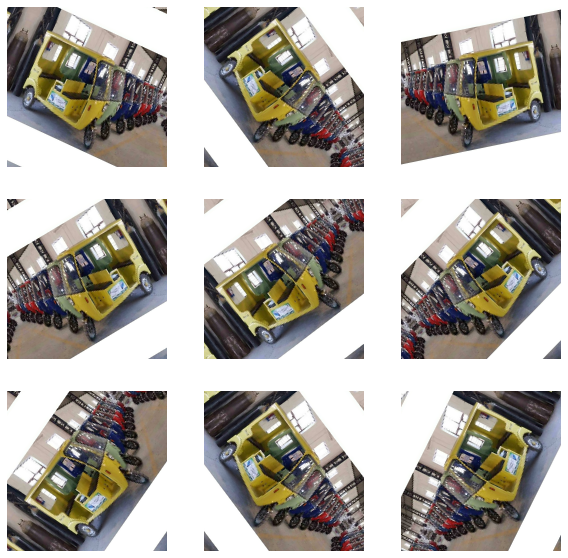

In [12]:
# augmenting the train set

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [13]:
# rescaling pixel values

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### Feature Extraction

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

In [14]:
# intialize the base model here and print the model summary

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. 

In [17]:
# Freeze the base Model
base_model.trainable = False

In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [19]:
# Add your desired classification head and initalize new model

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = tf.keras.layers.Dense(3, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [21]:
# building model

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
# compile the model and print the summary

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(), # from_logits=True
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [24]:
len(model.trainable_variables)

2

In [25]:
# train the model (seeing initial loss and accuracy)

loss0, accuracy0 = model.evaluate(validation_dataset)

1/1 [==============================] - 2s 2s/step - loss: 1.7806 - accuracy: 0.4375


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.78
initial accuracy: 0.44


In [27]:
# fit the model

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/70
7/7 [==============================] - 4s 207ms/step - loss: 1.5393 - accuracy: 0.3317 - val_loss: 1.0856 - val_accuracy: 0.4688
Epoch 2/70
7/7 [==============================] - 1s 118ms/step - loss: 1.0496 - accuracy: 0.5240 - val_loss: 0.5623 - val_accuracy: 0.7812
Epoch 3/70
7/7 [==============================] - 1s 115ms/step - loss: 0.8242 - accuracy: 0.6298 - val_loss: 0.6955 - val_accuracy: 0.6562
Epoch 4/70
7/7 [==============================] - 1s 117ms/step - loss: 0.5821 - accuracy: 0.7740 - val_loss: 0.4085 - val_accuracy: 0.9062
Epoch 5/70
7/7 [==============================] - 1s 117ms/step - loss: 0.5585 - accuracy: 0.7740 - val_loss: 0.4305 - val_accuracy: 0.9062
Epoch 6/70
7/7 [==============================] - 1s 115ms/step - loss: 0.4466 - accuracy: 0.7981 - val_loss: 0.2774 - val_accuracy: 0.9375
Epoch 7/70
7/7 [==============================] - 1s 120ms/step - loss: 0.4010 - accuracy: 0.8269 - val_loss: 0.2369 - val_accuracy: 0.9375
Epoch 8/70
7/7 [====

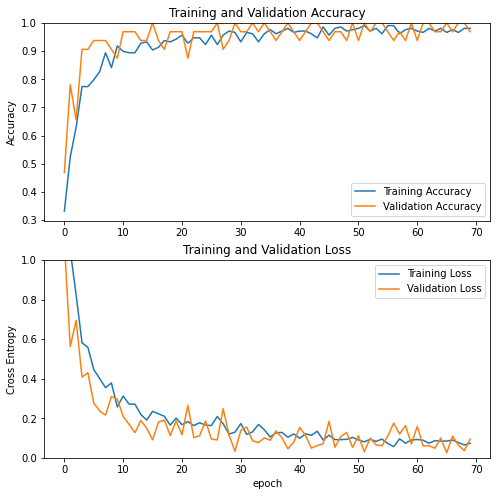

In [28]:
# plot the loss and accuracy curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine Tuning

In the feature extraction, you were only training a few layers on top of a base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In [29]:
# unfreeze the base model

base_model.trainable = True

In [30]:
# print the number of layers in the base model

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


You should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [31]:
# Decide the number of layers you want to freeze and freeze them.

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [32]:
# compile the model again.
# It is advisable to use a lower learning rate here so that updates are not too huge and the model does not overfit.
# print model summary

model.compile(loss=tf.losses.CategoricalCrossentropy(), # from_logits=True
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [34]:
len(model.trainable_variables)

56

In [35]:
# fit the model again.

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 70/140
7/7 [==============================] - 6s 273ms/step - loss: 2.0138 - accuracy: 0.6588 - val_loss: 0.6397 - val_accuracy: 0.8438
Epoch 71/140
7/7 [==============================] - 1s 135ms/step - loss: 0.7504 - accuracy: 0.7203 - val_loss: 1.1427 - val_accuracy: 0.5625
Epoch 72/140
7/7 [==============================] - 1s 128ms/step - loss: 0.6247 - accuracy: 0.7610 - val_loss: 0.3974 - val_accuracy: 0.8125
Epoch 73/140
7/7 [==============================] - 1s 135ms/step - loss: 0.4684 - accuracy: 0.7957 - val_loss: 0.5262 - val_accuracy: 0.7812
Epoch 74/140
7/7 [==============================] - 1s 129ms/step - loss: 0.6108 - accuracy: 0.7181 - val_loss: 0.5191 - val_accuracy: 0.7812
Epoch 75/140
7/7 [==============================] - 1s 130ms/step - loss: 0.3619 - accuracy: 0.8314 - val_loss: 0.3652 - val_accuracy: 0.8750
Epoch 76/140
7/7 [==============================] - 1s 129ms/step - loss: 0.4817 - accuracy: 0.8229 - val_loss: 0.1711 - val_accuracy: 0.9062
Epoch 

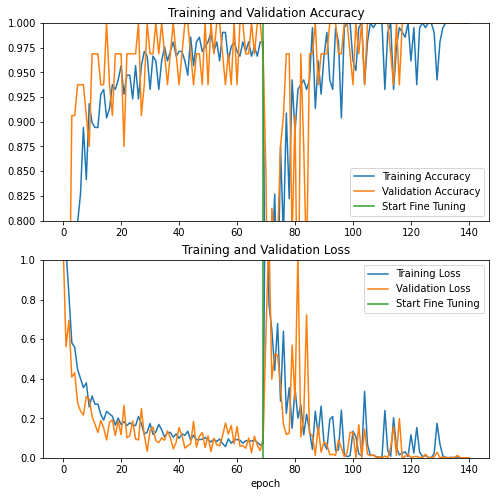

In [36]:
# plot the loss and accuracy curves again

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Prediction

Now we will use our model to make predictions on test set. Store the predictions like in sample_submission.csv file. 

sample_submission.csv
- 4 columns
- 1 row for each test image (total 853 rows)
- 1st column = image file name
- 2nd column = probability of the given image being qingqi
- 3rd column = probability of the given image being rickshaw
- 4th column = probability of the given image being tanga

In [37]:
# Read and preprocess test data. Remeber to store the names of image files

testingImages = glob.glob('/content/gdrive/MyDrive/CS437_Deep_Learning/HW3_21100157/PartC/VehicleDataset/test/*',  recursive = True) 
print('Length of testing_paths list: ', len(testingImages))

id = []
for path in testingImages:
  id.append(path.split('/')[9].split('.')[0]) # image file name

Length of testing_paths list:  853


In [38]:
qingqi = []
rickshaw = []
tanga = []
def preprocessAndPredict(im):
  global qingqi
  global rickshaw
  global tanga
  img = keras.preprocessing.image.load_img(im, target_size=(160, 160))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  predictions = model.predict(img_array)
  qingqi.append(predictions[0][0])
  rickshaw.append(predictions[0][1])
  tanga.append(predictions[0][2])

In [39]:
# predict on test data (Hint: model.predict())

for i in range(len(testingImages)):
  preprocessAndPredict(testingImages[i])

In [40]:
# store the predictions in a .csv file like in sample_submission.csv (Hint: pandas may be helpful here)

dict = {'id': id, 'qingqi': qingqi, 'rickshaw': rickshaw, 'tanga': tanga}
df = pd.DataFrame(dict)
df

,id,qingqi,rickshaw,tanga
0,f10446237,1.676011e-08,1.000000e+00,1.000558e-13
1,f16778691,3.421554e-08,1.000000e+00,1.029834e-11
2,f12813737,9.999932e-01,6.179688e-06,6.111815e-07
3,f12710145,7.333314e-12,3.431748e-16,1.000000e+00
4,f11867174,1.508921e-06,9.999920e-01,6.485545e-06
...,...,...,...,...
848,f92185311,1.711268e-16,3.781770e-16,1.000000e+00
849,f94200622,4.321812e-11,7.223698e-12,1.000000e+00
850,f95250641,2.719768e-13,1.000000e+00,1.873221e-14
851,f84927066,2.806534e-11,9.760267e-16,1.000000e+00


In [41]:
df.to_csv('/content/gdrive/MyDrive/CS437_Deep_Learning/HW3_21100157/PartC/21100157_predictions.csv', index=False)